In [ ]:
#!pip install "pandas<2.0.0"
#!pip install "pytorch-forecasting[mqf2]<1.0.0"
#!pip install numpy matplotlib pyarrow
#!pip install rasterio

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl

In [ ]:
BASE_PATH = '/media/data'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
RESULT_PATH = os.path.join(BASE_PATH, 'results')

LAG = 52
LEAD = 8

TEST_PERIOD = (pd.Timestamp(2014, 1, 5), pd.Timestamp(2015, 12, 27))

TIME_IDX = pd.date_range('1990-01-01', freq='W-SUN', periods=1357, name='time').to_frame().reset_index(drop=True)
TIME_IDX.index.name = 'time_idx'
TIME_IDX = TIME_IDX.reset_index()

## Data

In [ ]:
static_df = pd.read_feather(os.path.join(DATA_PATH, 'static_map.feather'))
df = pd.read_feather(os.path.join(DATA_PATH, 'temporal_map.feather'))
df = df[df['time_idx'].between(DATE_RANGE.set_index('time').loc[TEST_PERIOD[0], 'time_idx'], DATE_RANGE.set_index('time').loc[TEST_PERIOD[1], 'time_idx'])]
df = df.merge(TIME_IDX, on='time_idx', how='left')
df = df.merge(static_df, on=['y', 'x'], how='left', suffixes=('', '_static'))
df['proj_id'] = df['y'].astype('str') + '_' + df['x'].astype('str')

# encode day of the year as circular feature
df['day_sin'] = np.sin(2*np.pi / 365. * df['time'].dt.dayofyear).astype(np.float32)
df['day_cos'] = np.cos(2*np.pi / 365. * df['time'].dt.dayofyear).astype(np.float32)

df

In [ ]:
static_df['land_cover'] = static_df['land_cover'].astype('category')
static_df['rock_type'] = static_df['rock_type'].astype('category')
static_df['permeability'] = static_df['permeability'].astype('category')
static_df['cavity_type'] = static_df['cavity_type'].astype('category')
static_df['geochemical_rock_type'] = static_df['geochemical_rock_type'].astype('category')

In [ ]:
N_REF_WELLS = 100

ref_proj_ids = [
    'BB_33522338', 'BB_34402050', 'BB_34426100', 'BB_36441970',
    'BB_39431451', 'BW_100-517-0', 'BW_100-813-7', 'BW_101-713-8',
    'BW_101-812-0', 'BW_103-714-0', 'BW_103-763-0', 'BW_104-112-1',
    'BW_107-309-4', 'BW_107-517-2', 'BW_107-666-2', 'BW_109-812-6',
    'BW_110-116-6', 'BW_111-568-6', 'BW_111-813-7', 'BW_115-113-3',
    'BW_115-114-5', 'BW_116-721-2', 'BW_119-765-9', 'BW_119-771-0',
    'BW_119-813-3', 'BW_122-021-6', 'BW_125-257-2', 'BW_131-115-0',
    'BW_132-721-5', 'BW_135-064-6', 'BW_135-769-9', 'BW_139-119-9',
    'BW_145-771-8', 'BW_154-772-0', 'BW_156-770-6', 'BW_158-767-0',
    'BW_160-768-0', 'BW_164-772-6', 'BW_170-772-3', 'BW_172-772-2',
    'BW_177-772-5', 'BW_188-258-0', 'BW_193-769-2', 'BW_2010-813-1',
    'BW_4-812-8', 'BW_59-568-8', 'BY_11148', 'BY_83614', 'BY_9182',
    'HE_11738', 'HE_12447', 'HE_13622', 'HE_5754', 'HE_5798',
    'HE_6336', 'HE_6615', 'HE_7095', 'HE_7945', 'HE_8106', 'HE_8126',
    'HE_8999', 'HE_9534', 'HE_9595', 'HE_9620', 'HE_9692',
    'NI_100000467', 'NI_100000644', 'NI_100000670', 'NI_100000730',
    'NI_100000732', 'NI_100000914', 'NI_200000660', 'NI_200001410',
    'NI_40501911', 'NI_40502371', 'NI_40507101', 'NI_40507140',
    'NI_9700168', 'NI_9700201', 'NW_110320037', 'NW_129660334',
    'NW_59620286', 'NW_60100205', 'NW_70195213', 'NW_70195316',
    'NW_70276018', 'NW_80100247', 'NW_80301680', 'NW_91122405',
    'NW_91130104', 'NW_91141102', 'NW_91167309', 'NW_91173607',
    'SH_10L56010001', 'SN_49420761', 'SN_49430964', 'SN_53403678',
    'SN_54403689', 'ST_31380006', 'ST_41300022'
]

In [ ]:
ref_df = pd.read_feather(os.path.join(DATA_PATH, 'temporal.feather'))
ref_df = ref_df[ref_df['proj_id'].isin(ref_proj_ids)]
ref_df = ref_df.set_index(['time', 'proj_id'])['gwl'].unstack()
ref_df.columns = [f'ref_well_{i}' for i in range(N_REF_WELLS)]
ref_df

In [ ]:
df = df.merge(ref_df, left_on='time', right_index=True, how='left')
df

In [ ]:
from pytorch_forecasting import TimeSeriesDataSet

train_ds = TimeSeriesDataSet.load('train_tft_global_interpolation.pt')

In [ ]:
test_ds = TimeSeriesDataSet.from_dataset(train_ds, df)
test_dataloader = test_ds.to_dataloader(train=False, batch_size=2048, num_workers=2)

In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer

model = TemporalFusionTransformer.load_from_checkpoint('/media/data/lightning_logs/tft_global_interpolation_new/checkpoints/epoch=2-step=14817.ckpt')

In [ ]:
predictions, index = model.predict(test_dataloader, mode="prediction", return_index=True, show_progress_bar=True)
predictions = predictions.numpy()
np.save(os.path.join(RESULT_PATH, 'predictions', 'tft_map_predictions.npy'), predictions)
index.to_feather(os.path.join(RESULT_PATH, 'predictions', 'tft_map_prediction_index.feather'))

In [ ]:
from utils import predictions_to_df

HEIGHT = 800
WIDTH = 610

predictions_df = predictions_to_df(index, predictions.T, ['proj_id'], TIME_IDX, LEAD)
predictions_df = predictions_df.loc[:, :, 1]
predictions_df = predictions_df[(predictions_df.index.get_level_values('horizon') == 1) | (predictions_df.index.get_level_values('time') > pd.Timestamp(2015, 11, 15))]
predictions_df = predictions_df.droplevel(2)
static_df = pd.read_feather(os.path.join(DATA_PATH, 'static_map.feather'))
static_df['proj_id'] = static_df['y'].astype('str') + '_' + static_df['x'].astype('str')
static_df = static_df[['proj_id', 'y', 'x']]
predictions_df = predictions_df.reset_index().merge(static_df, on=['proj_id']).drop(columns=['proj_id'])
predictions_df = predictions_df.merge(df[(df['gwl_observed']) & (df['time'].between(predictions_df['time'].min(), predictions_df['time'].max()))][['y', 'x', 'time', 'gwl']], on=['time', 'y', 'x'], how='outer')
predictions_df['gwl'] = predictions_df['gwl'].fillna(predictions_df['forecast'])
predictions_df = predictions_df.set_index(['time', 'y', 'x'])[['gwl']]
predictions_df = predictions_df.groupby(level=[0, 1, 2]).mean()
multi_index = pd.MultiIndex.from_product([
    pd.date_range(predictions_df.index.get_level_values('time').min(), predictions_df.index.get_level_values('time').max(), freq='W-SUN'),
    pd.RangeIndex(HEIGHT), 
    pd.RangeIndex(WIDTH), 
], names=['time', 'y', 'x'])
_df = predictions_df.reindex(multi_index).unstack()
map_data = _df.values.reshape((int(_df.values.shape[0]/HEIGHT), HEIGHT, WIDTH))

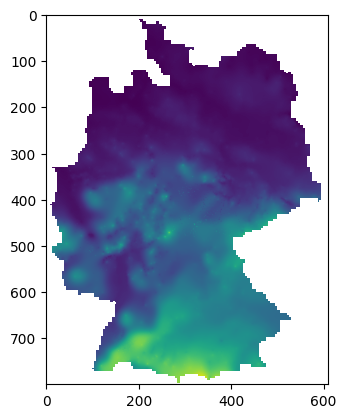

In [337]:
from matplotlib import pyplot as plt

plt.imshow(map_data[0]);

In [ ]:
import rasterio

profile = {
    'dtype': 'float32', 
    'nodata': np.nan, 
    'width': WIDTH, 
    'height': HEIGHT, 
    'crs': rasterio.CRS.from_epsg(3034), 
    'transform': rasterio.Affine(1000.0, 0.0, 3730587.581246662, 0.0, -1000.0, 3111462.13962283),
    'count': map_data.shape[0]
}

with rasterio.open(os.path.join(os.path.join(RESULT_PATH, 'gwl_map_2015_01_04-2015_12_28.tif')), 'w', **profile) as dst:
    for i, band in enumerate(map_data, start=1):
        dst.write_band(i, band)